<a href="https://colab.research.google.com/github/chieuanh2910/TweetSentiments/blob/main/Tweet_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet sentiment analytics

## Table of Content

1. [Executive Summary](#cell_executivesummary)


2. [Data Exploration](#cell_exploration)


3. [Sentiment Analysis](#cell_sentiment)


4. [Topic Modeling](#cell_TopicModeling)


5. [Practical Implication](#cell_PracticalImplication)


<a id = "cell_executivesummary"></a>
### 1. Executive Summary


This analysis delves into the sentiment of airline tweets using a Python-based approach. The dataset was meticulously explored, revealing valuable insights into the opinions and feelings of customers towards different airlines.

Among the significant findings, it was observed that United Airlines emerged as the most talked-about airline, generating 3822 tweets, closely followed by US Airways and American Airlines. In terms of geographic distribution, the top five states with the highest customer engagement were identified as New York, California, Texas, Massachusetts, and North Carolina.

The analysis employed two predictive models, Multinomial Naive Bayes and Random Forest, to forecast tweet sentiment. These models allowed for a comprehensive understanding of the general sentiment trend across the different airlines.

Upon further examination, it was observed that United Airlines stood out with the highest proportion of positive tweets, while US Airways faced a higher proportion of negative sentiment.

To extract deeper insights, Latent Dirichlet Allocation (LDA) technique was applied for topic modeling. The technique unveiled ten distinct topics, with the most prevalent negative issues revolving around prolonged waiting times, customer service concerns, booking system difficulties, and subpar phone call experiences.

In summary, this analysis has successfully utilized Python to explore and interpret the sentiment of airline tweets. By identifying trends, opinions, and critical topics, the study provides a comprehensive overview of customer perceptions and experiences, allowing airlines to make informed decisions and improvements.

<a id = "cell_exploration"></a>
### 2. Data Exploration



This part is started with dataset import. The dataset containes 14640 rows and 15 columns. The columns: tweet_id, airline_sentiment, airline_sentiment_confidence, airline, name, retweet_count, text, tweet_created have no missing values. Among column having missing vaues, airline_sentiment_gold and negativereason_gold have the higgest amount of null values. The dataset consists of 36 duplicated rows with are then removed before further analysis.  

Based on the bar graph, United airline is the most poular with 3822 tweets. US Airways takes the second position with 2913 twweets, American being the third with 2723 tweets. Southwest and Delta is in the fourth and the fifth popularity respectively. Last is Virgin America airline with only 504 tweets

The top 5 most popular states are New York (NY), Calfifornia (CA), Texas (TX), Massachusetts (MA), and North Carolina (NC). There are 257 customers in NY, 244 in CA, 166 in TX, 154 in MA, and 78 in NC.

**Import Dataset**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
import matplotlib.pyplot as plt
import os
import seaborn as sns
from functools import reduce


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MIS780 Dataset/A1 Data Set.csv')

In [ ]:
df.shape

(14640, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

**Check for duplicated rows**






In [ ]:
num_duplicated_rows = df.duplicated().sum()

print("Number of duplicated rows:", num_duplicated_rows)

Number of duplicated rows: 36


**Remove duplicated rows**




In [ ]:
df = df.drop_duplicates()

**Airline popularity ranking**

In [ ]:
airline_counts = df['airline'].value_counts()
airline_counts

United            3822
US Airways        2913
American          2723
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

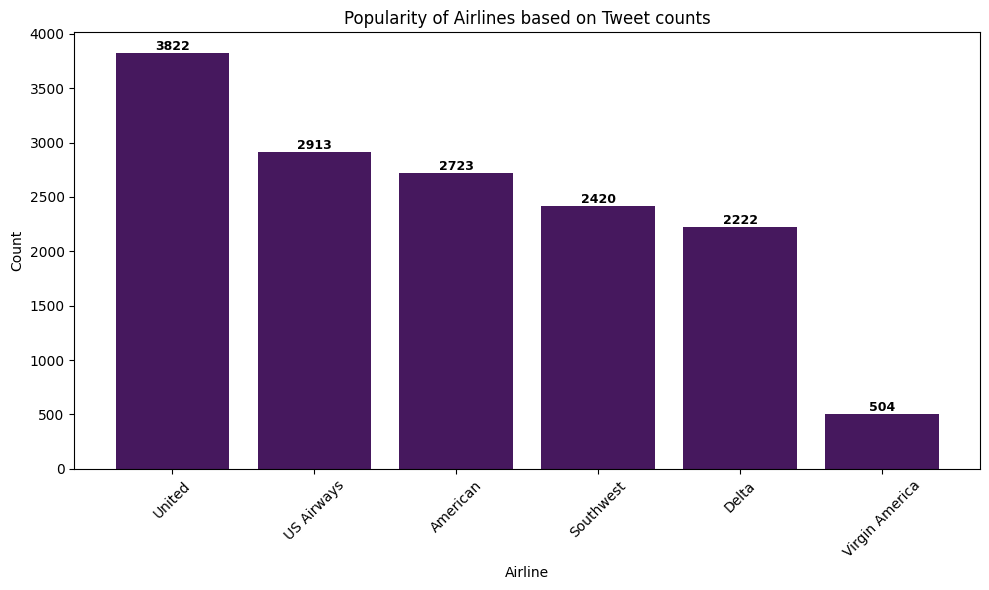

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(airline_counts.index, airline_counts, color='#46185e')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Popularity of Airlines based on Tweet counts')
plt.xticks(rotation=45)
for x, y in zip(airline_counts.index, airline_counts):
    plt.text(x, y, str(y), ha='center', va='bottom', color='black', fontweight='bold',fontsize=9)
plt.tight_layout()


**Most popular states**

In [ ]:
#extract customer location by State
pattern = r'\b(AL|AK|AZ|AR|CA|CO|CT|DE|FL|GA|HI|ID|IL|IN|IA|KS|KY|LA|ME|MD|MA|MI|MN|MS|MO|MT|NE|NV|NH|NJ|NM|NY|NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY)\b'
df['State'] = df['tweet_location'].str.extract(pattern)

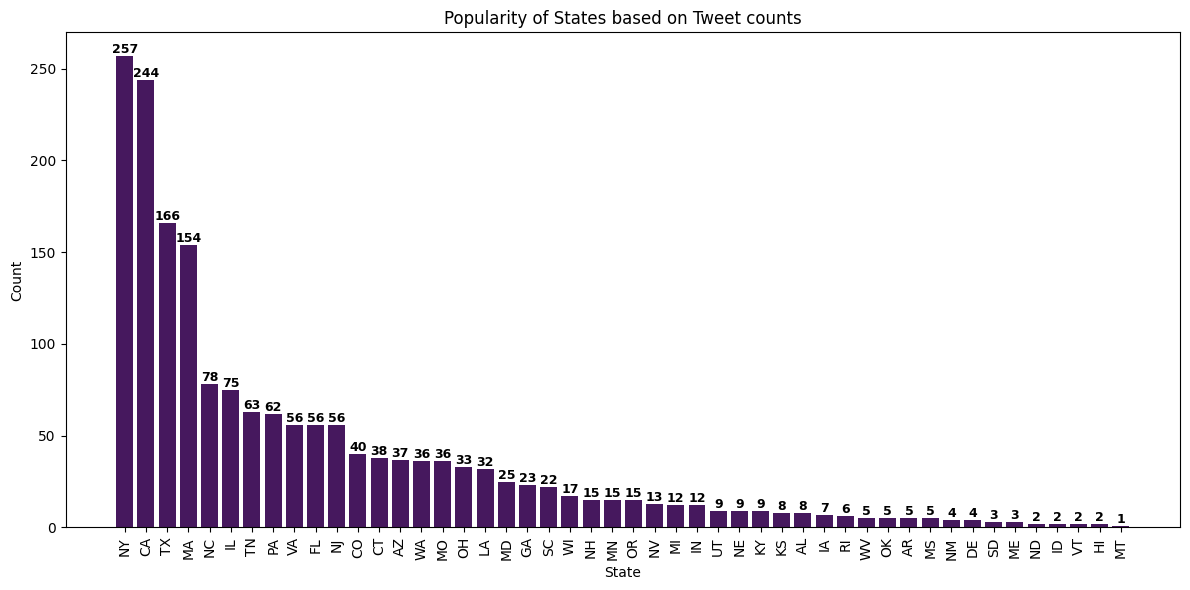

In [ ]:
#Count unique customer in each State
state_counts = df.groupby('State')['name'].nunique()
state_counts = state_counts.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(state_counts.index, state_counts, color='#46185e')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Popularity of States based on Tweet counts')
plt.xticks(rotation=90)
for x, y in zip(state_counts.index, state_counts):
    plt.text(x, y, str(y), ha='center', va='bottom', color='black', fontweight='bold',fontsize=9)
plt.tight_layout()
plt.show()


<a id = "cell_sentiment"></a>
### 3. Sentiment Analysis

It is possible to predict tweet's sentiments using machine learning approach. The Multimonimal Naive Bayes and Randon Forest models will be applied to do the prediction.The feature variable will be texts in 'text' column, and the label will be airline_sentiment column.

The preprocessing steps include remove number and symbols such as "<br/>", "(<a)", "(>)", etc to return a cleaner text. The clean text will then be removed from common stop words to create bag of word (BoW) matrix which is helpful to train the models.

The models are split into 70% for training, and 30% for testing. The dataset will be reduced dmensionality through Univariate selection method in order to have better result for the Random Forest model.

**Result interpretation for Multinomial Naive Bayes model**

The model accuracy is 0.749

Classification Report:
```
                 precision    recall  f1-score   support

    Positive       0.77      0.93      0.84      2741
     Neutral       0.64      0.38      0.48       936
    Negative       0.73      0.52      0.61       715

    accuracy                           0.75      4392
   macro avg       0.71      0.61      0.64      4392
weighted avg       0.74      0.75      0.73      4392

```
Precision measures how many of the predicted positive instances are actually positive. For this model report, the precision for Positive sentiment is 77%, Neutral sentiment is 64%, and Negative sentiment is 73%.

Recall is the measure of how many of the actual positive instances are correctly predicted. Recall for Positive sentiment is 93%, Neutrals sentiment is 38%, and Negative sentiment is 52%.

F1-score is a metric which takes into account both precision and recall. It is calculated as 2 * (precision * recall) / (precision + recall). In this report, F1-score for Positive sentiment is 0.84, Neutral sentiment is 0.48, and Negative sentiment is 0.61.

Weighted Average: The average of precision, recall, and F1-score, weighted by the number of true instances for each class. It accounts for class imbalance

It can bee seen that this model appears to perform well in predicting the "Positive" sentiment class  with high precision and recall. However it struggles with the "Neutral" and "Negative" classes, especically in terms of recall.

**Result interpretation for Random Forest model**
```
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.90      0.84      2741
     neutral       0.58      0.45      0.51       936
    positive       0.72      0.56      0.63       715

    accuracy                           0.75      4392
   macro avg       0.70      0.64      0.66      4392
weighted avg       0.74      0.75      0.74      4392
```
For this model report, the precision for Neagtive sentiment is 79%, Neutral sentiment is 58%, and Postive sentiment is 72%.

Recall for Negative sentiment is 90%, Neutrals sentiment is 45%, and Positive sentiment is 56%.

F1-score for Negative sentiment is 0.84, Neutral sentiment is 0.51, and Positive sentiment is 0.63.

It can bee seen that this model appears to perform well in predicting the "Negative" sentiment class  with high precision and recall. However it struggles with the "Neutral" while "Positive" classes seems to be moderately well.

**Clean text processes**

In [ ]:
def preprocess(Text):
    Text = Text.str.replace("(<br/>)", "")
    Text = Text.str.replace('(<a).*(>).*(</a>)', '')
    Text = Text.str.replace('(&amp)', '')
    Text = Text.str.replace('(&gt)', '')
    Text = Text.str.replace('(&lt)', '')
    Text = Text.str.replace('(\xa0)', ' ')
    return Text

df['text'] = preprocess(df['text']) #Clean text

#Create new feature for the length of the review.
df['text_len'] = df['text'].astype(str).apply(len)
#Create new feature for the word count of the review.
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

<ipython-input-14-91332f32e17f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  Text = Text.str.replace("(<br/>)", "")
<ipython-input-14-91332f32e17f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  Text = Text.str.replace('(<a).*(>).*(</a>)', '')
<ipython-input-14-91332f32e17f>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  Text = Text.str.replace('(&amp)', '')
<ipython-input-14-91332f32e17f>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  Text = Text.str.replace('(&gt)', '')
<ipython-input-14-91332f32e17f>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  Text = Text.str.replace('(&lt)', '')
<ipython-input-14-91332f32e17f>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  Text = Text.st

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,State,text_len,word_count
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),NaN,35,4
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),NaN,72,9
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),NaN,71,12
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),NaN,122,17
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),NaN,55,10


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

text_counts = cv.fit_transform(df['text'])
print('Bag of Word Matrix size: ', text_counts.shape)
print('Data in the first row:\n', text_counts[1,:])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Bag of Word Matrix size:  (14604, 14796)
Data in the first row:
   (0, 14047)	1
  (0, 10274)	1
  (0, 13968)	1
  (0, 1959)	1
  (0, 3970)	1
  (0, 5582)	1
  (0, 12738)	1


**Model training**

In [ ]:
#Split dataset for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['airline_sentiment'], test_size=0.3, random_state=1)

**MULTINOMIAL NAIVE BAYES**

MultinomialNB Accuracy: 0.749


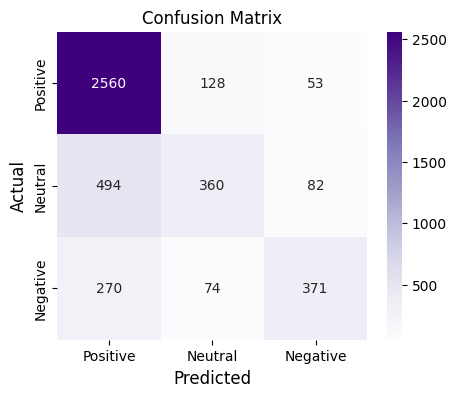

Classification Report:
              precision    recall  f1-score   support

    Positive       0.77      0.93      0.84      2741
     Neutral       0.64      0.38      0.48       936
    Negative       0.73      0.52      0.61       715

    accuracy                           0.75      4392
   macro avg       0.71      0.61      0.64      4392
weighted avg       0.74      0.75      0.73      4392



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, predicted)
cm_df = pd.DataFrame(cm,
                     index = ['Positive','Neutral','Negative'],
                     columns = ['Positive','Neutral','Negative'])

print("MultinomialNB Accuracy:", round(metrics.accuracy_score(y_test, predicted),3))

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.ylabel('Actual', fontsize = 12)
plt.xlabel('Predicted', fontsize = 12)
plt.show()

# Create a classification report
class_report = classification_report(y_test, predicted, target_names=['Positive', 'Neutral', 'Negative'])

# Print the classification report
print("Classification Report:")
print(class_report)

**Univariate selection**

In [ ]:
from sklearn.feature_selection import SelectKBest

#Get the target label
Target = df['airline_sentiment']
#We will select the top 100 features
test = SelectKBest(k=100)
#Fit the function for ranking the features by score
fit = test.fit(text_counts, Target)
UnivariateFeatures = fit.transform(text_counts)
print('Reduced Data Set size:',UnivariateFeatures.shape)

Reduced Data Set size: (14604, 100)


**RANDOM FOREST MODEL**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Create and fit the random forest model
random_forest_model = RandomForestClassifier(random_state=1)
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

cm_df2 = pd.DataFrame(conf_matrix,
                     index = ['Negative','Neutral','Positive'],
                     columns = ['Negative','Neutral','Positive'])

print("RF Accuracy:", round(metrics.accuracy_score(y_test, predicted),3))

plt.figure(figsize=(5,4))
sns.heatmap(cm_df2, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.ylabel('Actual', fontsize = 12)
plt.xlabel('Predicted', fontsize = 12)
plt.show()

print("Classification Report:\n", classification_rep)

NameError: ignored

**Lexicon Based Approach**



Based on the airline popularity chart, the top three airlines are United, US Airways, and American. To find out tweet sentiments for these airlines, the lexicon based approach will be used with the aid of nltk.sentiment library.

The proportion of posittive, neutral, and negative tweets for **United airline** is as below:
```
positive    52.846076 %
neutral     27.921859 %
negative    19.232065 %
```
This means that more than 50% customer feel positive about United airline.

The proportion of posittive, neutral, and negative tweets for **US Airways** is as below:
```
positive    47.664399
neutral     29.841270
negative    22.494331
```
47.66% customers have positive sentiment towards US Airways. Interestingly, neutral and negative sentiments are quite close (29.84% and 22.49% resepctively)

The proportion of posittive, neutral, and negative tweets for **American** is as below:
```
positive    51.284447
neutral     27.557216
negative    21.158337
```
The positive sentiment percentage is also higher than neutral and  positive for American airline, accounting for 51.28%.

It is helpful to compare all the sentiment propotion accross all three airlines. Based on the Sentiment Distribution Comparison chart, it can be seen that for Positive sentiment, United airline is the highest while US Airways is the least. However, US Airways has highest percentage when it comes to Neutral and Negative sentiments. The neutral proportion of United and American are quite close while American is the sencond highest in negative sentiment.  

Thus, among these three airlines, United received more positive sentiments than ngeative sentiments from customers.

In [ ]:
united_df = df[df['airline'] == 'United']
usairways_df = df[df['airline'] =='US Airways']
american_df = df[df['airline'] == 'American']

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
#Initialize an instance of SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

united_df['score'] = united_df['text'].apply(lambda txt: sid.polarity_scores(txt))


<ipython-input-83-5bd5f55f97ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_df['score'] = united_df['text'].apply(lambda txt: sid.polarity_scores(txt))


In [ ]:
united_df['negative'] = united_df['score'].apply(lambda txt: txt['neg'])
united_df['neutral'] = united_df['score'].apply(lambda txt: txt['neu'])
united_df['positive'] = united_df['score'].apply(lambda txt: txt['pos'])
united_df['compound'] = united_df['score'].apply(lambda txt: txt['compound'])

<ipython-input-84-f421b8e65136>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_df['negative'] = united_df['score'].apply(lambda txt: txt['neg'])
<ipython-input-84-f421b8e65136>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_df['neutral'] = united_df['score'].apply(lambda txt: txt['neu'])
<ipython-input-84-f421b8e65136>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.5:
        return "negative"
    elif compound >= -0.05 and compound < 0.05:
        return "neutral"

In [ ]:
united_df['sentiment'] = united_df['compound'].apply(lambda val: polarity_score(val))

united_df['sentiment'].value_counts(normalize = True) *100

<ipython-input-86-36af005b66d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  united_df['sentiment'] = united_df['compound'].apply(lambda val: polarity_score(val))


positive    52.846076
neutral     27.921859
negative    19.232065
Name: sentiment, dtype: float64

In [ ]:
usairways_df['score'] = usairways_df['text'].apply(lambda txt: sid.polarity_scores(txt))

<ipython-input-87-fb576b814d36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usairways_df['score'] = usairways_df['text'].apply(lambda txt: sid.polarity_scores(txt))


In [ ]:
usairways_df['negative'] = usairways_df['score'].apply(lambda txt: txt['neg'])
usairways_df['neutral'] = usairways_df['score'].apply(lambda txt: txt['neu'])
usairways_df['positive'] = usairways_df['score'].apply(lambda txt: txt['pos'])
usairways_df['compound'] = usairways_df['score'].apply(lambda txt: txt['compound'])

<ipython-input-88-6bcd740a721c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usairways_df['negative'] = usairways_df['score'].apply(lambda txt: txt['neg'])
<ipython-input-88-6bcd740a721c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usairways_df['neutral'] = usairways_df['score'].apply(lambda txt: txt['neu'])
<ipython-input-88-6bcd740a721c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
usairways_df['sentiment'] = usairways_df['compound'].apply(lambda val: polarity_score(val))

usairways_df['sentiment'].value_counts(normalize = True) *100

<ipython-input-89-29b685ffa3f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usairways_df['sentiment'] = usairways_df['compound'].apply(lambda val: polarity_score(val))


positive    47.664399
neutral     29.841270
negative    22.494331
Name: sentiment, dtype: float64

In [ ]:
american_df['score'] = american_df['text'].apply(lambda txt: sid.polarity_scores(txt))

<ipython-input-90-76a65ec17237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_df['score'] = american_df['text'].apply(lambda txt: sid.polarity_scores(txt))


In [ ]:
american_df['negative'] = american_df['score'].apply(lambda txt: txt['neg'])
american_df['neutral'] = american_df['score'].apply(lambda txt: txt['neu'])
american_df['positive'] = american_df['score'].apply(lambda txt: txt['pos'])
american_df['compound'] = american_df['score'].apply(lambda txt: txt['compound'])

<ipython-input-91-e4e0756b5f1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_df['negative'] = american_df['score'].apply(lambda txt: txt['neg'])
<ipython-input-91-e4e0756b5f1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_df['neutral'] = american_df['score'].apply(lambda txt: txt['neu'])
<ipython-input-91-e4e0756b5f1b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [ ]:
american_df['sentiment'] = american_df['compound'].apply(lambda val: polarity_score(val))

american_df['sentiment'].value_counts(normalize = True) *100

<ipython-input-92-f827b3f72a0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  american_df['sentiment'] = american_df['compound'].apply(lambda val: polarity_score(val))


positive    51.284447
neutral     27.557216
negative    21.158337
Name: sentiment, dtype: float64

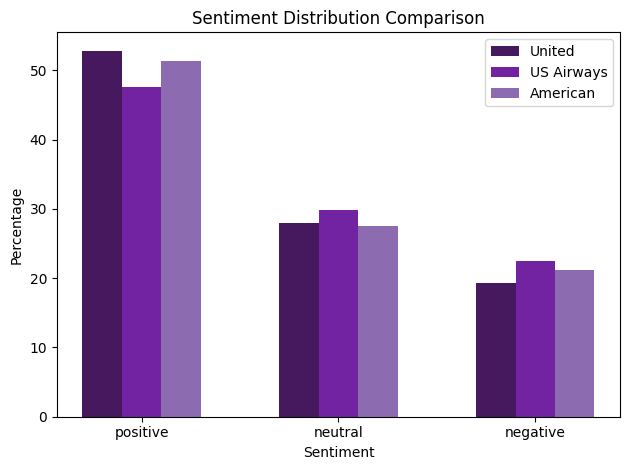

In [ ]:
united_sentiment_counts = united_df['sentiment'].value_counts(normalize=True) * 100
usairways_sentiment_counts = usairways_df['sentiment'].value_counts(normalize=True) * 100
american_sentiment_counts = american_df['sentiment'].value_counts(normalize=True) * 100



labels = united_sentiment_counts.index
x = range(len(labels))

width = 0.2  # width of the bars
plt.bar(x, united_sentiment_counts, width, label='United', color='#46185e')
plt.bar([i + width for i in x], usairways_sentiment_counts, width, label='US Airways', color='#7123a1')
plt.bar([i + 2 * width for i in x], american_sentiment_counts, width, label='American', color='#8c6bb1')

plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution Comparison')
plt.xticks([i + width for i in x], labels)
plt.legend()
plt.tight_layout()

plt.show()

<a id = "cell_TopicModeling"></a>
### 4. Topic Modeling



In order to find out the common negative issues mentioned by customers, all negative tweets will be stored to a new dataframe for easy processing. There are 9159 tweets in this new dataframe.

The tweets will be cleaned by removing numbers, symbols, and common stop words. Since the dataframe consists of only negative sentiment, the cleaned texts will be then extracted to use on nouns. By ussng CountVectorzier, a document-term matrix is created with the dimension of 9159 rows and 5285 columns (terms).

Before perform topic modelling, names of airlines are in the top 40 common mentioned words, followed by others such as 'service', 'customer', or 'hours' to name but a few. Since these common words could affect the modelling, they will be removed under the conditions if the their frequency is higher than 20% and lower than 1%.

By performing LDA with 10 number of topics, the word clouds for each topic is created for eay interpretation.
- Topic 1: Customers are negative about people and the waiting minutes (queuing time)
- Topic 2: Customers complain about American airline and their seats in the plane and calls to the airline
- Topic 3: Customers mentioned negatively about the booking system and the time they spent with it. They also mentioned Jetblue airline which is not in the list of airline of this dataset. This could be interpreted that Jetblue is superior in terms of bookng system.
- Topic 4: Customers complain about long hours to purchase tickets via American airline website
- Topic 5: Customers feel negative customer serrvice in helping them to claim baggage, or finding seat number
- Topic 6: Customers are mostly not favour of agents in the cheking areas
- Topic 7: Customers do not feel positive about US Airways with their flights, reservation, or baggage
- Topic 8: Customers do not feel positive about Southwest airline with their delay, or luggage experience
- Topic 9: Customers mainly talk negatively about airline delay or the agents/staff at the customs gates
- Topic 10: Customers do not feel positive about American airline with their flights if they need help via phone calls.

Among 10 topics, topic 10 has the most popular while topic 3 & 4 are at the second positions.


In [ ]:
negative_df = df.loc[df['airline_sentiment'] == 'negative']
negative_df = negative_df.reset_index(drop=True)


In [ ]:
negative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9159 entries, 0 to 9158
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      9159 non-null   int64  
 1   airline_sentiment             9159 non-null   object 
 2   airline_sentiment_confidence  9159 non-null   float64
 3   negativereason                9159 non-null   object 
 4   negativereason_confidence     9159 non-null   float64
 5   airline                       9159 non-null   object 
 6   airline_sentiment_gold        32 non-null     object 
 7   name                          9159 non-null   object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 9159 non-null   int64  
 10  text                          9159 non-null   object 
 11  tweet_coord                   661 non-null    object 
 12  tweet_created                 9159 non-null   object 
 13  twe

In [ ]:
negative_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_len,word_count
0,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),122,17
1,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55,10
2,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),135,23
3,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),45,6
4,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),137,27


In [ ]:
from nltk.stem import PorterStemmer #Stemming Package
import re  #Regular expression operation package

porter = PorterStemmer()

documents = negative_df['text']
Cleaned_doc = []
for r in range(len(documents)):
    review = documents[r]
    try:
        # removing everything except alphabets
        review = re.sub('[^A-Za-z]', ' ', review)
        # make all text lowercase
        review = review.lower()
        # apply tokenization
        Tokens = review.split()
        # removing short words
        Filtered_token = [w for w in Tokens if len(w)>3]
        review = ' '.join(Filtered_token)
    except:
        continue
    #Save cleaned text
    Cleaned_doc.append(review)
for i in range(5):
    print('-[Review Text]:', Cleaned_doc[i])

-[Review Text]: virginamerica really aggressive blast obnoxious entertainment your guests faces they have little recourse
-[Review Text]: virginamerica really thing about
-[Review Text]: virginamerica seriously would flight seats that didn have this playing really only thing about flying
-[Review Text]: virginamerica schedule still
-[Review Text]: virginamerica flew from last week couldn fully seat large gentleman either side help


In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')

# Remove Stop Words
for r in range(len(Cleaned_doc)):
    each_item = []
    for t in Cleaned_doc[r].split():
        if t not in stop_words:
             each_item.append(t)
    Cleaned_doc[r] = ' '.join(each_item)
for i in range(5):
    print('-[Cleaned Text]: ', Cleaned_doc[r])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


-[Cleaned Text]:  americanair money change flight answer phones suggestions make commitment
-[Cleaned Text]:  americanair money change flight answer phones suggestions make commitment
-[Cleaned Text]:  americanair money change flight answer phones suggestions make commitment
-[Cleaned Text]:  americanair money change flight answer phones suggestions make commitment
-[Cleaned Text]:  americanair money change flight answer phones suggestions make commitment


In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from nltk import pos_tag

stop_words = stopwords.words('english')

# Remove Stop Words and extract nouns using Part-of-Speech tagging
for r in range(len(Cleaned_doc)):
    each_item = []
    for t in Cleaned_doc[r].split():
        if t not in stop_words:
            each_item.append(t)

    # Perform Part-of-Speech tagging on cleaned text
    pos_tagged = pos_tag(nltk.word_tokenize(' '.join(each_item)))

    # Extract only nouns
    nouns = [term for term, pos in pos_tagged if pos.startswith('NN')]

    # Store the extracted nouns back in Cleaned_doc
    Cleaned_doc[r] = ' '.join(nouns)
for i in range(5):
    print('-[Cleaned Text with Extracted Nouns]:', Cleaned_doc[r])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


-[Cleaned Text with Extracted Nouns]: money change flight answer phones suggestions commitment
-[Cleaned Text with Extracted Nouns]: money change flight answer phones suggestions commitment
-[Cleaned Text with Extracted Nouns]: money change flight answer phones suggestions commitment
-[Cleaned Text with Extracted Nouns]: money change flight answer phones suggestions commitment
-[Cleaned Text with Extracted Nouns]: money change flight answer phones suggestions commitment


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()# Fit and transform the processed titles

count_data = count_vectorizer.fit_transform(Cleaned_doc)
count_data

<9159x5285 sparse matrix of type '<class 'numpy.int64'>'
	with 42884 stored elements in Compressed Sparse Row format>

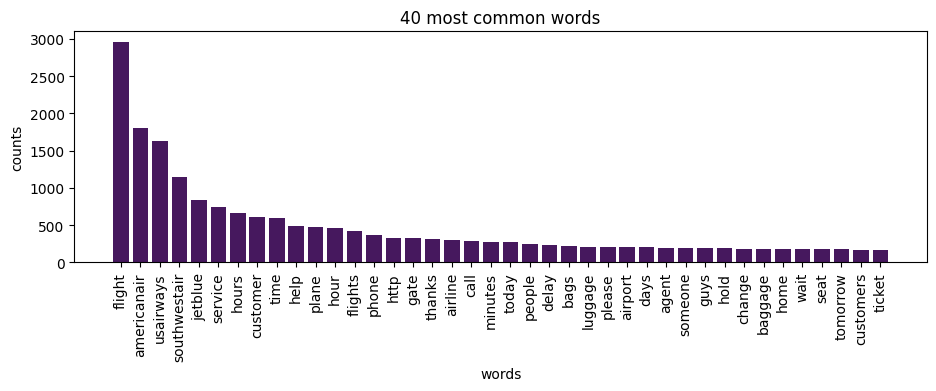

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
terms = count_vectorizer.get_feature_names_out()

# Count the popularity of words
total_counts = np.zeros(len(terms))
for t in count_data:
    total_counts+=t.toarray()[0]

count_dict = (zip(terms, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:40] #Take the top 40 words

words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(11, 3))
plt.subplot(title='40 most common words')
plt.bar(words, counts, color = '#46185e')
plt.xticks(x_pos, words, rotation=90 )
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

In [ ]:
#Remove highly frequent (Greater than 20%) and infrequent words (less than 1%)
keepIndex = [];
for t in range(len(total_counts)):
    if total_counts[t] < 1836 and total_counts[t] > 92:
        keepIndex.append(t)

print('Number of Terms Remained: ', len(keepIndex))

#Save the remain ing term and frequency data
ReducedTerm = [terms[t] for t in keepIndex]
ReducedCount = count_data[:,keepIndex]
ReducedCount

Number of Terms Remained:  77


<9159x77 sparse matrix of type '<class 'numpy.int64'>'
	with 20265 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Tweak the two parameters below
number_topics = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=2023)
lda.fit(ReducedCount)
#Trained LDA model
lda.components_

array([[1.00006852e-01, 1.00005563e-01, 1.00004908e-01, 1.00003733e-01,
        2.08099964e+02, 1.55848119e+02, 1.00006933e-01, 1.00009393e-01,
        1.00005383e-01, 2.75799026e+01, 1.00005124e-01, 1.00004071e-01,
        1.00009415e-01, 1.00004543e-01, 1.00007678e-01, 1.00002057e-01,
        1.00004877e-01, 1.00005235e-01, 1.69099967e+02, 1.00005407e-01,
        1.00002837e-01, 1.00002992e-01, 1.00003913e-01, 1.00003055e-01,
        1.00003172e-01, 1.00006416e-01, 1.00006486e-01, 1.00008286e-01,
        1.00008834e-01, 1.00005980e-01, 1.00003152e-01, 1.00007795e-01,
        1.00005437e-01, 1.16387661e-01, 1.00004268e-01, 1.00004418e-01,
        1.00005088e-01, 1.00004831e-01, 1.21832827e+02, 1.00006412e-01,
        1.00002745e-01, 1.00004438e-01, 2.70099962e+02, 1.00003826e-01,
        1.01113942e-01, 1.00005415e-01, 1.00008818e-01, 1.00004389e-01,
        2.42099973e+02, 1.00006201e-01, 1.00010900e-01, 1.00003696e-01,
        1.00009986e-01, 1.00008667e-01, 1.00001685e-01, 1.000086

In [ ]:
#Word Probablities in Topics
Word_Topics_Pro = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(Word_Topics_Pro)

[[6.65288345e-05 6.65279770e-05 6.65275408e-05 6.65267594e-05
  1.38436994e-01 1.03676833e-01 6.65288882e-05 6.65305249e-05
  6.65278571e-05 1.83473305e-02 6.65276848e-05 6.65269839e-05
  6.65305396e-05 6.65272979e-05 6.65293839e-05 6.65256446e-05
  6.65275205e-05 6.65277585e-05 1.12492529e-01 6.65278729e-05
  6.65261633e-05 6.65262662e-05 6.65268788e-05 6.65263086e-05
  6.65263862e-05 6.65285441e-05 6.65285910e-05 6.65297882e-05
  6.65301526e-05 6.65282542e-05 6.65263727e-05 6.65294617e-05
  6.65278930e-05 7.74260490e-05 6.65271155e-05 6.65272153e-05
  6.65276606e-05 6.65274895e-05 8.10484063e-02 6.65285413e-05
  6.65261022e-05 6.65272281e-05 1.79682044e-01 6.65268209e-05
  6.72653176e-05 6.65278780e-05 6.65301419e-05 6.65271957e-05
  1.61055254e-01 6.65284014e-05 6.65315268e-05 6.65267347e-05
  6.65309192e-05 6.65300418e-05 6.65253967e-05 6.65299997e-05
  9.32004918e-02 6.65253702e-05 6.65267304e-05 6.65277897e-05
  6.65316267e-05 6.65295996e-05 8.98742759e-02 6.65254433e-05
  6.6533

In [ ]:
for topic_idx, topic in enumerate(Word_Topics_Pro):
    print("\nTopic #%d:" % topic_idx)
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:5]
    for w in count_dict:
        print(w[0], ': {0:.3f}'.format(w[1]))


Topic #0:
minutes : 0.180
people : 0.161
airport : 0.138
customers : 0.112
americanair : 0.104

Topic #1:
plane : 0.266
call : 0.160
americanair : 0.103
seats : 0.083
flightr : 0.076

Topic #2:
jetblue : 0.372
time : 0.266
days : 0.093
system : 0.061
miles : 0.053

Topic #3:
hours : 0.230
http : 0.140
americanair : 0.097
hold : 0.079
change : 0.065

Topic #4:
service : 0.375
customer : 0.307
baggage : 0.092
seat : 0.090
number : 0.034

Topic #5:
today : 0.184
virginamerica : 0.114
agents : 0.093
check : 0.090
connection : 0.088

Topic #6:
usairways : 0.840
phone : 0.031
help : 0.030
reservation : 0.029
someone : 0.017

Topic #7:
southwestair : 0.548
luggage : 0.101
home : 0.087
experience : 0.074
times : 0.058

Topic #8:
hour : 0.212
gate : 0.150
airline : 0.137
delay : 0.110
agent : 0.092

Topic #9:
americanair : 0.316
flights : 0.125
help : 0.103
phone : 0.088
thanks : 0.054


In [ ]:
# View full Word Probabilities by Topic Matrix
df_topic_keywords = pd.DataFrame(Word_Topics_Pro)
df_topic_keywords.columns = ReducedTerm
df_topic_keywords

,agent,agents,airline,airlines,airport,americanair,anyone,anything,baggage,bags,...,times,today,tomorrow,travel,trip,usairways,virginamerica,wait,weather,work
0,0.000067,0.000067,0.000067,0.000067,0.138437,0.103677,0.000067,0.000067,0.000067,0.018347,...,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.017717,0.000067,0.000067
1,0.000055,0.000055,0.000055,0.000055,0.000055,0.102626,0.000055,0.000055,0.000055,0.000055,...,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.015144,0.000055,0.000055
2,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,0.010314,0.000045,0.000045
3,0.000042,0.000042,0.000042,0.000042,0.000042,0.096624,0.000042,0.000042,0.000042,0.055814,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.063347,0.000042
4,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.029579,0.092076,0.000050,...,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050
5,0.000068,0.093017,0.000068,0.066363,0.000068,0.000997,0.000068,0.000068,0.000068,0.000068,...,0.000068,0.183916,0.000068,0.070463,0.000068,0.000068,0.114204,0.000068,0.000068,0.000068
6,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052,0.012351,...,0.015041,0.000052,0.000052,0.000052,0.000052,0.839999,0.000052,0.000052,0.000052,0.011641
7,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.017621,...,0.057674,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.039148,0.000048,0.009754
8,0.092092,0.000046,0.136720,0.000046,0.000046,0.082708,0.000046,0.000046,0.000046,0.000046,...,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,0.011040,0.000046,0.000046
9,0.000030,0.000030,0.000030,0.000030,0.000030,0.316154,0.031150,0.012382,0.000030,0.000030,...,0.000030,0.000030,0.052694,0.000030,0.038630,0.000030,0.000030,0.000030,0.000030,0.026777


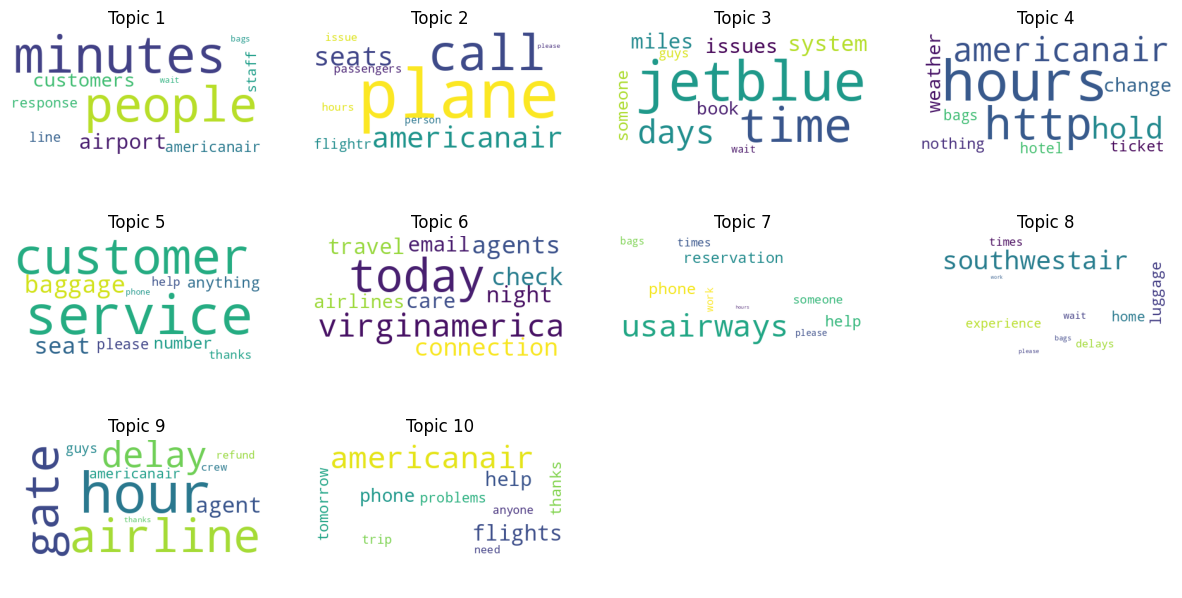

In [ ]:
!pip install wordcloud
from matplotlib import pyplot

from wordcloud import WordCloud
import math
rows = math.ceil(len(Word_Topics_Pro)/4)
fig, ax = pyplot.subplots(rows, 4, figsize=(15,2.5*rows))
[axi.set_axis_off() for axi in ax.ravel()]
for topic_idx, topic in enumerate(Word_Topics_Pro):
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    # convert to dictionary type - keep top 10 words
    Word_Frequency = dict(count_dict[0:10])
    # generate word cloud
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)
    # visualize word cloud in figure
    subfig_Row = math.floor(topic_idx/4)
    subfig_Col = math.ceil(topic_idx%4)
    ax[subfig_Row,subfig_Col].imshow(wordcloud)
    ax[subfig_Row,subfig_Col].set_title("Topic {}".format(topic_idx+1))
plt.show()




**Visualize the popularity of each topic**

In [ ]:
#Compute topic distribution for each document
TopicDis_Doc = lda.transform(ReducedCount)

#Compute overall topic distribution for all each documents
Overall_Topic_Dis = sum(TopicDis_Doc)/sum(sum(TopicDis_Doc))
Overall_Topic_Dis

array([0.08212522, 0.08837262, 0.10870249, 0.10645079, 0.09100338,
       0.08019944, 0.09933443, 0.10467259, 0.09883519, 0.14030385])

In [ ]:
TopicDis_Doc.shape

(9159, 10)

In [ ]:
#Find the highest proababilities of the topics
np.argmax(TopicDis_Doc, axis = 1 )

array([5, 5, 5, ..., 7, 0, 3])

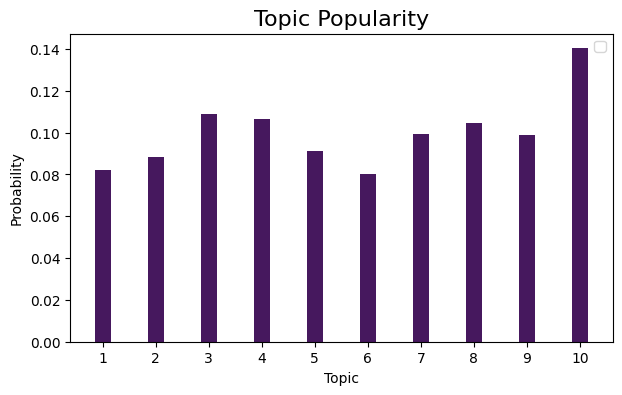

In [ ]:
# Get the topic index
Bar_index = np.asarray(range(1,number_topics+1))

#Visualize topic distributions of review groups
pyplot.figure(figsize=(7,4))
pyplot.title('Topic Popularity', fontsize=16)
pyplot.xlabel('Topic')
pyplot.ylabel('Probability')
pyplot.bar(Bar_index, Overall_Topic_Dis.tolist(), 0.3, color='#46185e')
pyplot.xticks(Bar_index, Bar_index)
pyplot.legend()
pyplot.show();

<a id = "cell_Practicalimplication"></a>
### 5. Practical Implication

Based on the finding of the analysis, business could identify the areas where customers feel negative to improve. Airlines could improve customers waiting time in queue by hiring more cheking agents or adopt self-checking machines to fasten the checking process. Booking systmem are also mentioned frequently as an issue due to customers havng to spend lots of time on the system. Thus, airlines could upgrade their booking systmem infrasctructure to enable customers make bookings more convenient. It it notable that Jetblue airline is mentioned here as a better option for customers, which could be an indicator that customers might leave to another competitor. It is worth to study more how Jetblue provide service and then adopt new startegies to win customers. Customer service is also an aspect to be improved especially with the staff and the phone service. It seems that customer's opinion about phone calls to customer service to be negative. Airline could tackle this issue by training their customer service staff more, or hiring more staff to meet with the number of calling inquries.

Although this analysis does not dive deeper in positive and neutral sentiments, these opinions could provide insignts to improve business. They can look at positive commments to create an upsell strategies to convert customers with positive sentiments to become loyal flyers, or they can provide promotion to neutral people to convert them to choose the airline for future travel. It is also good to look at what competitors are doing to create a response plan. For example if JetBlue is good with their booking system, then American airline could focus on improving its booking system first to win customers back rather than other innovation in its business actio plan.   

